# Expanding on Ito et al. (2017) to recover simulated task activity and connectivity matrix


Set up environment

In [1]:
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm

Import custom modules

In [2]:
sys.path.append('../')
sys.path.append('../../utils/')

# Primary module with most model functions
import model

# Module for FC regression
import multregressionconnectivity as mreg

Helper functions

In [3]:
phi = lambda x: np.tanh(x)

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


## Neural network model

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}


where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The effect of this transformation can be seen below in the attenuated signal of the transformed timeseries.

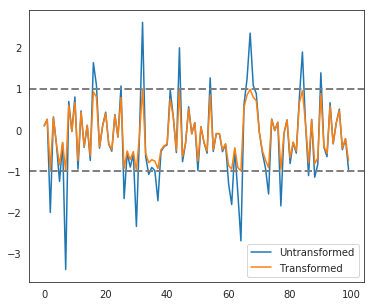

In [4]:
plt.rcParams["figure.figsize"][0] = 6
plt.rcParams["figure.figsize"][1] = 5
a = np.random.normal(size=100)
pa = phi(a)
plt.plot(a, label="Untransformed")
plt.plot(pa, label="Transformed")
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axhline(y=-1,linewidth=2, color='gray', ls = "--")
plt.legend()

In Ito et al. (2017) $\tau_i$, $s$ and $g$ are set to 1. This simplifies the equation to:

\begin{equation*}
x_i(t) + \frac{dx_i}{dt} = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

\begin{equation*}
x_i(t+1) = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

vectorizing the matrix multiplication

\begin{equation*}
x_i(t+1) = \phi\big(x_i(t)\big) + w_{i1}\phi\big(x_1(t)\big) + w_{i2}\phi\big(x_2(t)\big)... +  w_{iN}\phi\big(x_N(t)\big) + I_i(t)
\end{equation*}

with the observable activity levels in each node at every time point we should be able to use a regression framework to receover the weights in the connectivity matrix.

\begin{equation*}
x_i(t+1) = \beta_{1}\phi\big(x_i(t)\big) + \beta_{2}\phi\big(x_1(t)\big) + \beta_{3}\phi\big(x_2(t)\big) ... +  \beta_{N}\phi\big(x_N(t)\big) + \beta_{N+1}I_i(t)
\end{equation*}

Thus $\beta_1$ should be recursivity (and 1) while all the other parameter estimates should map onto the afferent/incoming connection weights

***Create structural and synaptic network***

One hub and two local networks

In [5]:
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

In [6]:
# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=False)

Text(0.5, 1.0, 'Synaptic Weight Matrix -- Coupling Matrix')

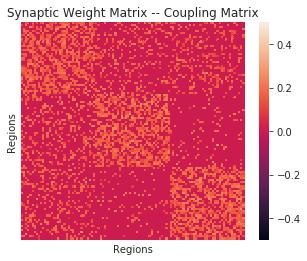

In [7]:
plt.rcParams["figure.figsize"][0] = 5
plt.rcParams["figure.figsize"][1] = 4
sns.heatmap(G, xticklabels=False, yticklabels=False,                 
            vmin = -.5, vmax = .5)
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.title("Synaptic Weight Matrix -- Coupling Matrix")

Note in this matrix:

`G[..., x]` : column x of matrix denotes all outgoing connection weights from node x  
`G[x, ...]` : row x of matrix denotes all incoming connection weights to node x

In [8]:
## Set up simulation parameters
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0

### Task activity 

***Hub network stimulation***

In [13]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
Tmax = 100000 

T = np.arange(0,Tmax,dt)
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
        tasktiming[0,t] = 1.0

Block design where stimulus is ON for 500 ms every 2 seconds looks like:

(-0.1, 1.2)

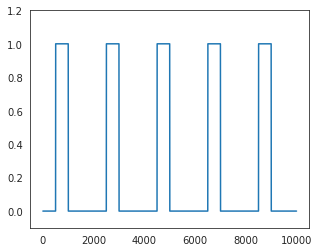

In [14]:
plt.plot(T[:10000], tasktiming[0,:10000])
plt.ylim(top = 1.2, bottom = -0.1)

In [17]:
stimtimes = {}

topdown_only = range(1,2)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/3.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

# When task is ON the activity for a stim_node at that time point is .5
for t in range(len(T)):
    if tasktiming[0,t] == 1:
        stimtimes[task][stim_nodes,t] = .5

Activated nodes in the hub network *only* (making it a top-down task) are:

In [18]:
stim_nodes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

`taskdata` is an $n$ by $t$ matrix containing the timeseries for each node where $n$-rows are for nodes and $t$ columns are for the time points.

It is generated by updating each column (each time point) for **all nodes**  

At each time point the differential equation (above) describing the change in activity is solved using the Runge-Kutta second order method.

\begin{equation*}
\frac{dx_i}{dt} = \frac{-x_i(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + s\phi\big(x_i(t)\big) + I_i(t)}{\tau_i}
\end{equation*}

Thus `taskdata` for all nodes $x_*$

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{k1_{i}+k2_{i}}{2}
\end{equation*}

where  

\begin{equation*}
k1_{i} = \frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + I_{i}(t)}{\tau}
\end{equation*}

so the intermediate approximation is

\begin{equation*}
x_{i}^*(t+dt) = x_{i}(t) + k1_{i} dt
\end{equation*}

and the second order approximation for the change in activity is

\begin{equation*}
k2_{i} = \frac{-x_{i}^*(t+dt) + g\Bigg(W \cdot \phi\big(I_{i}(t+dt)\big) \Bigg) + s\phi\big(x_{i}^*(t+dt)\big) + I_{i}(t)}{\tau}
\end{equation*}


Traditional task-based fmri GLM analyses use nodes as units of analysis and model the whole time series of a **single node** 

So the timeseries of a node would be modeled as a function of convolved task activity ($I(t)*h(t)$), confounds and error.

\begin{equation*}
Y_{n}(*) = I_n(t)*h(t) + confounds + error
\end{equation*}


In [ ]:
out = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)
taskdata = out[0]
noise = out[1]
#taskdata = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
#                                          I=stimtimes[task], noise=1)

## Extending GLM to recover true task activity and connectivity matrix

Note: Extending the GLM in this way is intended to account for the connectivity between nodes and how **task** activity in the previous step affects task activity in the current step for a given node. I don't think this is the same thing as 'subtracting out' resting state to look at the remaining task activity.

Understanding how the data are generated using the Runge-Kutta second order method

https://lpsa.swarthmore.edu/NumInt/NumIntSecond.html

In [ ]:
#Using first third of the data for speed of estimation
taskdata_short = copy.copy(taskdata[:,:15000])

In [ ]:
x = copy.copy(stimtimes[task][0,:15000].T)
y = copy.copy(taskdata_short)
I = stimtimes[task][:,:15000]

In [ ]:
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 4
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

#Anticipated problems
df = pd.DataFrame(data = {'a':np.repeat(np.arange(0,1,.1), 10), 'b': np.tile(np.arange(0,1,.1), 10)})
df['phi(a+b)'] = phi(df['a']+df['b'])
df['phi(a)+phi(b)'] = phi(df['a']) + phi(df['b'])

sns.regplot(x = 'phi(a+b)', y = 'phi(a)+phi(b)', data = df, ax = ax1)
ax1.plot((0, 1), (0, 1), 'k--', linewidth=3)

df = pd.DataFrame(data = {'a':np.repeat(np.arange(0,1,.1), 10), 'b': np.tile(np.arange(0,1,.1), 10)})
df['phi(a*b)'] = phi(df['a']*df['b'])
df['phi(a)*phi(b)'] = phi(df['a']) * phi(df['b'])

sns.regplot(x = 'phi(a*b)', y = 'phi(a)*phi(b)', data = df, ax = ax2)
ax2.plot((0, 1), (0, 1), 'k--', linewidth=3)

In [ ]:
ntimepoints = y.shape[1]
nregions = y.shape[0]

#Initialize empty variables
ucr_task = np.zeros((nregions))
ext_cur_node = np.zeros((nregions)) 
ext_weight_matrix = np.zeros((nregions, nregions-1))
ext_task = np.zeros((nregions))
ext_phi_weight_matrix = np.zeros((nregions, nregions-1))
ext_phi_phi_cur_node = np.zeros((nregions))
ext_phi_task = np.zeros((nregions))

In [ ]:
for region in range(0, nregions):
    
    cur_y = y[region,:]
    task_reg = I[region,:]

    ucr_mod = sm.OLS(cur_y, task_reg)
    ucr_res = ucr_mod.fit()
    ucr_task[region] = ucr_res.params[0]

    #Extended model 
    next_y = 2*cur_y[1:] #shift column up to predict next multiplied activity

    cur_y = cur_y[:-1] #drop last time point

    drop_region = [region]
    #other_ns_next_spont = np.delete(I, drop_region, axis=0)[:,1:] #dropping first col/timepoint
    other_ns_next_spont = np.delete(y, drop_region, axis=0)[:,1:]
    other_ns_next_spont = other_ns_next_spont.T

    cur_n_next_spont = I[region,1:]

    #other_ns_cur_spont = np.delete(I, drop_region, axis=0)[:,:-1] #dropping last col/timepoint
    other_ns_cur_spont = np.delete(y, drop_region, axis=0)[:,:-1]
    other_ns_cur_spont = other_ns_cur_spont.T
    other_ns_cur_spont = np.apply_along_axis(phi, 0, other_ns_cur_spont)

    cur_y_phi_phi = phi(phi(cur_y))

    cur_n_cur_spont = phi(I[region,:-1])

    ext_des_mat = np.concatenate((cur_y.reshape(-1,1), other_ns_next_spont), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_n_next_spont.reshape(-1,1)), 1)
    ext_des_mat = np.concatenate((ext_des_mat, other_ns_cur_spont), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_y_phi_phi.reshape(-1,1)), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_n_cur_spont.reshape(-1,1)), 1)

    ext_mod = sm.OLS(next_y, ext_des_mat)
    ext_res = ext_mod.fit()
    ext_params = ext_res.params

    ext_cur_node[region] = ext_params[0]
    ext_weight_matrix[region,:] = ext_params[1:nregions]
    ext_task[region] = ext_params[nregions]
    ext_phi_weight_matrix[region,:] = ext_params[nregions+1:2*nregions]
    ext_phi_phi_cur_node[region] = ext_params[-2]
    ext_phi_task[region] = ext_params[-1]

#### Task betas reduced after correction?


In [ ]:
task_betas = pd.DataFrame(data = {'ucr_task': ucr_task,
                         'ext_task': ext_task})

In [ ]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(task_betas['ucr_task'], color = "blue", label = "Classic GLM")
plt.plot(task_betas['ext_task'], color = "green", label = "Extended GLM")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='gray', ls = "--")
plt.axhline(y=0,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")

#### Current node betas == 1?

In [ ]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(ext_cur_node, color = "green",label = "Extended GLM current node")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")
plt.ylim(0.85, 1.2)

#### Other node betas recapitulate connectivity matrix?

**Relationship between other nodes betas and the afferent connectivity weights (can you recover the connectivity matrix?)**

In [ ]:
ext_weight_matrix_copy = copy.copy(ext_weight_matrix)
nregions = y.shape[0]
weight_matrix_betas = np.zeros((nregions,nregions))
for i in range(nregions):
    weight_matrix_betas[i] = np.insert(ext_weight_matrix_copy[i],i,0)

In [ ]:
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 4
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

sns.heatmap(G, ax=ax1, xticklabels=False, yticklabels=False,                 
            vmin = -.5, vmax = .5)
ax1.set_title("True")
sns.heatmap(weight_matrix_betas, ax=ax2, xticklabels=False, yticklabels=False,
            vmin = -.5, vmax = .5)
ax2.set_title("Estimated")